# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:16<00:00, 3.60kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

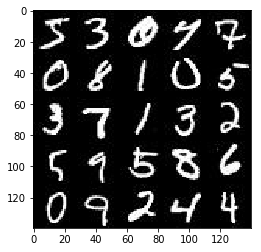

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

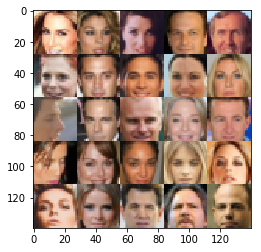

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/solomongebreyohannes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    ilearning_rate = tf.placeholder(tf.float32, name='learning_rate')    
    
    return inputs_real, inputs_z, ilearning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function 
    with tf.variable_scope('discriminator', reuse=reuse): 
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) 
        # 14x14x64 
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True) 
        relu2 = tf.maximum(alpha * bn2,  bn2) 
        # 7x7x128 
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True) 
        relu3 = tf.maximum(alpha * bn3, bn3) 
        # 7x7x256  
        
        # Flatten it 
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """ 
     
    # TODO: Implement Function 
    alpha=0.2  
    with tf.variable_scope('generator', reuse=not is_train): 
        
        # First layer 
        x1 = tf.layers.dense(z, 7*7*512) 
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) 
        # 7x7x512 
        
        # Second layer 
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train) 
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 
        
        # Third layer 
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same') 
        x3 = tf.layers.batch_normalization(x3, training=is_train) 
        x3 = tf.maximum(alpha * x3, x3) 
        # 28x28x128  
        
        # Forth layer 
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same') 
        x4 = tf.layers.batch_normalization(x4, training=is_train) 
        x4 = tf.maximum(alpha * x4, x4) 
        # 28x28x64  
        
        # Output layer 
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same') 
        # 28x28xout_channel_dim 
        
        out = tf.tanh(logits)    
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function 
    
    g_model = generator(input_z, out_channel_dim) 
    d_model_real, d_logits_real = discriminator(input_real) 
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True) 
     
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model 
    _, image_width, image_height, image_channels = data_shape
            
    input_real, input_z, ilearning_rate = model_inputs(image_width, image_height, image_channels, z_dim)  
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)  
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1) 
    
    print_every=10 
    show_every=100 
    # figsize=(5,5) 
    saver = tf.train.Saver() 
    steps = 0
    n_images = 25    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model 
                steps += 1 
                batch_images *= 2 
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, ilearning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images}) 
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images}) 

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0422... Generator Loss: 0.3906
Epoch 1/2... Discriminator Loss: 3.8266... Generator Loss: 0.1610
Epoch 1/2... Discriminator Loss: 3.2601... Generator Loss: 0.1223
Epoch 1/2... Discriminator Loss: 2.9110... Generator Loss: 0.1177
Epoch 1/2... Discriminator Loss: 2.5350... Generator Loss: 0.2502
Epoch 1/2... Discriminator Loss: 2.6809... Generator Loss: 0.1397
Epoch 1/2... Discriminator Loss: 2.3403... Generator Loss: 0.1924
Epoch 1/2... Discriminator Loss: 2.2016... Generator Loss: 0.3409
Epoch 1/2... Discriminator Loss: 2.2964... Generator Loss: 0.3294
Epoch 1/2... Discriminator Loss: 2.3118... Generator Loss: 0.2395


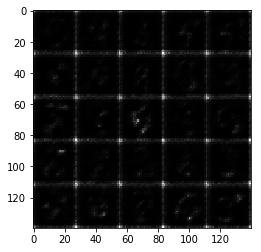

Epoch 1/2... Discriminator Loss: 2.0670... Generator Loss: 0.5029
Epoch 1/2... Discriminator Loss: 1.8455... Generator Loss: 0.5150
Epoch 1/2... Discriminator Loss: 1.8248... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 2.0134... Generator Loss: 0.4403
Epoch 1/2... Discriminator Loss: 1.9471... Generator Loss: 0.7479
Epoch 1/2... Discriminator Loss: 1.9104... Generator Loss: 0.3942
Epoch 1/2... Discriminator Loss: 1.9517... Generator Loss: 0.3863
Epoch 1/2... Discriminator Loss: 1.9134... Generator Loss: 0.3369
Epoch 1/2... Discriminator Loss: 1.8551... Generator Loss: 0.8366
Epoch 1/2... Discriminator Loss: 1.9711... Generator Loss: 0.2826


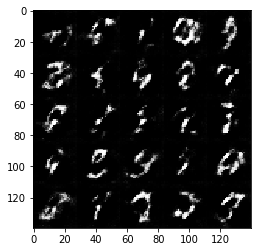

Epoch 1/2... Discriminator Loss: 1.8049... Generator Loss: 0.3816
Epoch 1/2... Discriminator Loss: 1.5772... Generator Loss: 0.7312
Epoch 1/2... Discriminator Loss: 1.6215... Generator Loss: 0.4538
Epoch 1/2... Discriminator Loss: 1.9900... Generator Loss: 0.2894
Epoch 1/2... Discriminator Loss: 1.6855... Generator Loss: 0.5269
Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 1.7901... Generator Loss: 0.5181
Epoch 1/2... Discriminator Loss: 2.0408... Generator Loss: 0.3341
Epoch 1/2... Discriminator Loss: 1.8902... Generator Loss: 0.2936
Epoch 1/2... Discriminator Loss: 1.8946... Generator Loss: 0.3138


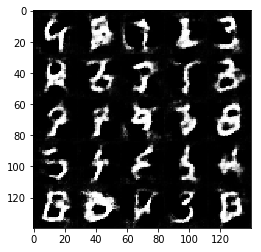

Epoch 1/2... Discriminator Loss: 1.6807... Generator Loss: 0.3974
Epoch 1/2... Discriminator Loss: 1.6412... Generator Loss: 0.5681
Epoch 1/2... Discriminator Loss: 1.6902... Generator Loss: 0.4259
Epoch 1/2... Discriminator Loss: 1.7771... Generator Loss: 0.3593
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.8693... Generator Loss: 0.3626
Epoch 1/2... Discriminator Loss: 1.7452... Generator Loss: 0.4381
Epoch 1/2... Discriminator Loss: 1.7490... Generator Loss: 0.4070
Epoch 1/2... Discriminator Loss: 1.6626... Generator Loss: 0.4243
Epoch 1/2... Discriminator Loss: 1.7493... Generator Loss: 0.3691


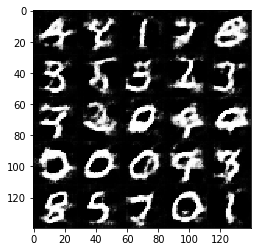

Epoch 1/2... Discriminator Loss: 1.8568... Generator Loss: 0.4402
Epoch 1/2... Discriminator Loss: 1.5388... Generator Loss: 0.5520
Epoch 1/2... Discriminator Loss: 1.8528... Generator Loss: 0.5145
Epoch 1/2... Discriminator Loss: 2.0303... Generator Loss: 0.2756
Epoch 1/2... Discriminator Loss: 1.6537... Generator Loss: 0.4424
Epoch 1/2... Discriminator Loss: 1.6630... Generator Loss: 0.4867
Epoch 1/2... Discriminator Loss: 1.5931... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.6243... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.6569... Generator Loss: 0.5972
Epoch 1/2... Discriminator Loss: 1.7865... Generator Loss: 0.3304


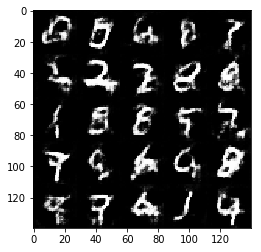

Epoch 1/2... Discriminator Loss: 1.5957... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 1.7640... Generator Loss: 0.5096
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.5405
Epoch 1/2... Discriminator Loss: 1.6607... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.7292... Generator Loss: 0.6807
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 1.7910... Generator Loss: 0.4110


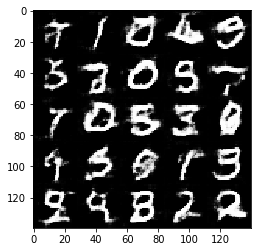

Epoch 1/2... Discriminator Loss: 1.6306... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 0.5998
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.5970
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 1.6355... Generator Loss: 0.4523
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.6425... Generator Loss: 0.6022
Epoch 1/2... Discriminator Loss: 1.6244... Generator Loss: 0.5860
Epoch 1/2... Discriminator Loss: 1.6821... Generator Loss: 0.5654
Epoch 1/2... Discriminator Loss: 1.6173... Generator Loss: 0.6461


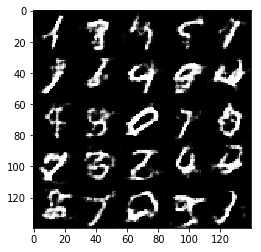

Epoch 1/2... Discriminator Loss: 2.0712... Generator Loss: 0.2776
Epoch 1/2... Discriminator Loss: 1.8053... Generator Loss: 0.4913
Epoch 1/2... Discriminator Loss: 1.7537... Generator Loss: 0.6386
Epoch 1/2... Discriminator Loss: 1.6890... Generator Loss: 0.5170
Epoch 1/2... Discriminator Loss: 1.4545... Generator Loss: 0.6681
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 1.2913
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.5605... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.6729... Generator Loss: 0.4124


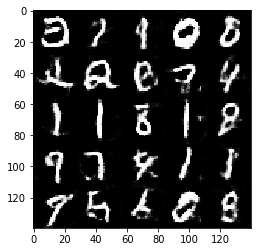

Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.7239
Epoch 1/2... Discriminator Loss: 1.7119... Generator Loss: 0.5238
Epoch 1/2... Discriminator Loss: 1.5532... Generator Loss: 0.4807
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 0.6092
Epoch 1/2... Discriminator Loss: 1.8627... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 1.4992... Generator Loss: 0.6612
Epoch 1/2... Discriminator Loss: 1.6591... Generator Loss: 0.4113
Epoch 1/2... Discriminator Loss: 1.8095... Generator Loss: 0.4054


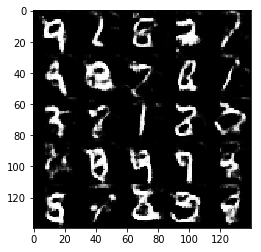

Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.5579... Generator Loss: 0.5544
Epoch 1/2... Discriminator Loss: 1.7454... Generator Loss: 0.3876
Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 0.5713
Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 0.6131
Epoch 1/2... Discriminator Loss: 1.5915... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 1.7229... Generator Loss: 0.3655
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.8765
Epoch 1/2... Discriminator Loss: 1.6598... Generator Loss: 0.4562
Epoch 1/2... Discriminator Loss: 1.5377... Generator Loss: 0.4789


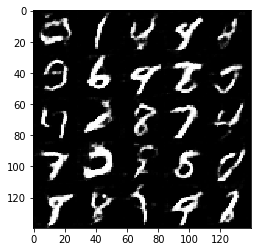

Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.5318
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.5654... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.6375
Epoch 1/2... Discriminator Loss: 1.5278... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 1.5497... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 1.7115... Generator Loss: 0.5191
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.8455
Epoch 1/2... Discriminator Loss: 1.6659... Generator Loss: 0.5657


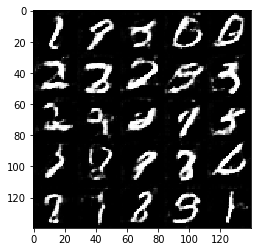

Epoch 1/2... Discriminator Loss: 1.6348... Generator Loss: 0.4806
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 1.7348... Generator Loss: 0.4293
Epoch 1/2... Discriminator Loss: 1.5878... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.6163... Generator Loss: 0.8484
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 1.5726... Generator Loss: 0.4358
Epoch 1/2... Discriminator Loss: 1.5609... Generator Loss: 0.7371
Epoch 1/2... Discriminator Loss: 1.5886... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.7436


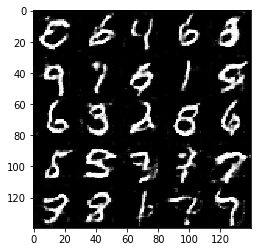

Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.5731... Generator Loss: 0.5076
Epoch 1/2... Discriminator Loss: 1.6937... Generator Loss: 0.4067
Epoch 1/2... Discriminator Loss: 1.5001... Generator Loss: 0.5960
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.4511
Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 1.5380... Generator Loss: 0.5163
Epoch 1/2... Discriminator Loss: 1.5089... Generator Loss: 0.5328
Epoch 1/2... Discriminator Loss: 1.7823... Generator Loss: 0.3524
Epoch 1/2... Discriminator Loss: 1.5606... Generator Loss: 0.4662


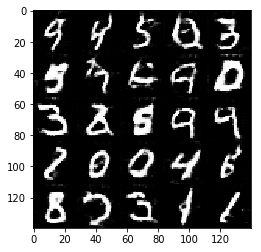

Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 1.7602... Generator Loss: 0.3737
Epoch 1/2... Discriminator Loss: 1.5027... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 1.5848... Generator Loss: 0.5112
Epoch 1/2... Discriminator Loss: 1.7072... Generator Loss: 0.4505
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.6547... Generator Loss: 0.3787
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.7056... Generator Loss: 0.3773


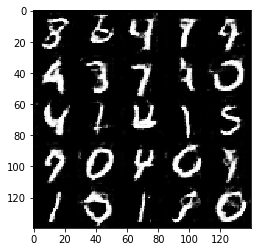

Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 0.5582
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.5311
Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 1.5701... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 1.5583... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.4844
Epoch 1/2... Discriminator Loss: 1.6031... Generator Loss: 1.0549
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 0.5664


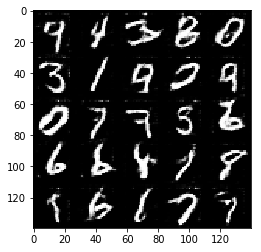

Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 0.4651
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.5920
Epoch 1/2... Discriminator Loss: 1.5988... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 1.4540... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.6046
Epoch 1/2... Discriminator Loss: 1.7175... Generator Loss: 0.4238


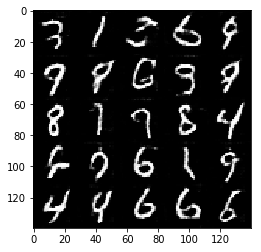

Epoch 1/2... Discriminator Loss: 1.5641... Generator Loss: 0.5151
Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.6026
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 1.7187... Generator Loss: 0.4530
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.8261


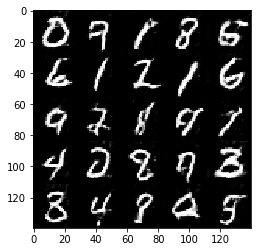

Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 0.8210
Epoch 1/2... Discriminator Loss: 1.5759... Generator Loss: 0.5320
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 1.5370... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.4917... Generator Loss: 0.5245
Epoch 1/2... Discriminator Loss: 1.6729... Generator Loss: 0.4736
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.5129... Generator Loss: 0.6261
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.6372


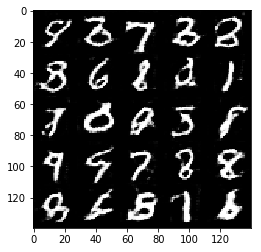

Epoch 1/2... Discriminator Loss: 1.5071... Generator Loss: 0.5093
Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.7265... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 0.5922
Epoch 1/2... Discriminator Loss: 1.5175... Generator Loss: 0.4625
Epoch 1/2... Discriminator Loss: 1.5781... Generator Loss: 0.5998
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 1.0647
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 1.1136
Epoch 2/2... Discriminator Loss: 1.5419... Generator Loss: 1.0638


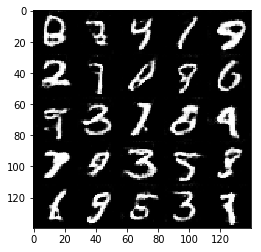

Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 1.5917... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 1.5548... Generator Loss: 0.4670
Epoch 2/2... Discriminator Loss: 1.4692... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.6630... Generator Loss: 0.5284
Epoch 2/2... Discriminator Loss: 1.5391... Generator Loss: 0.5539
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.5074
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.6204


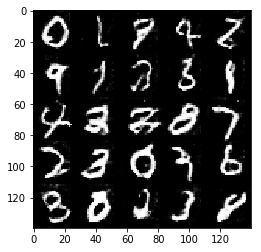

Epoch 2/2... Discriminator Loss: 1.4416... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.7768... Generator Loss: 0.3350
Epoch 2/2... Discriminator Loss: 1.2282... Generator Loss: 0.9101
Epoch 2/2... Discriminator Loss: 1.4409... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 1.5283... Generator Loss: 0.4866
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.5752
Epoch 2/2... Discriminator Loss: 1.6412... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.7825... Generator Loss: 0.3058
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.7839


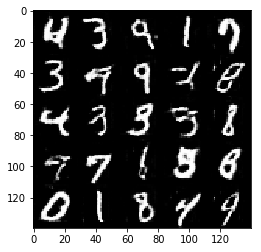

Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.5844
Epoch 2/2... Discriminator Loss: 1.6382... Generator Loss: 0.5335
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.9017
Epoch 2/2... Discriminator Loss: 1.7419... Generator Loss: 0.3744
Epoch 2/2... Discriminator Loss: 1.6410... Generator Loss: 0.4731
Epoch 2/2... Discriminator Loss: 1.6021... Generator Loss: 0.4800
Epoch 2/2... Discriminator Loss: 1.6128... Generator Loss: 0.8602
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.6230


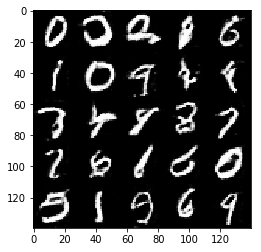

Epoch 2/2... Discriminator Loss: 1.5678... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.5075... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.5255
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.4866... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 1.2591... Generator Loss: 0.6807
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 1.4793... Generator Loss: 0.6175


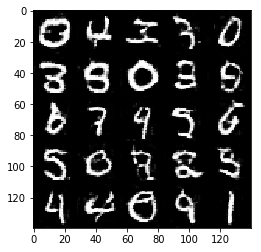

Epoch 2/2... Discriminator Loss: 1.5168... Generator Loss: 0.9687
Epoch 2/2... Discriminator Loss: 1.6006... Generator Loss: 0.4953
Epoch 2/2... Discriminator Loss: 1.7785... Generator Loss: 0.3935
Epoch 2/2... Discriminator Loss: 1.4396... Generator Loss: 0.5570
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.6011
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 1.0255
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.5610... Generator Loss: 0.4335


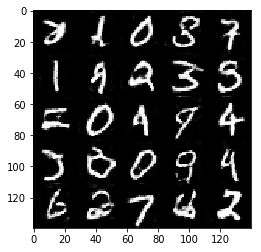

Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.8445
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.5730
Epoch 2/2... Discriminator Loss: 1.5611... Generator Loss: 0.9644
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.5758
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.6250
Epoch 2/2... Discriminator Loss: 1.5764... Generator Loss: 0.4785
Epoch 2/2... Discriminator Loss: 1.3555... Generator Loss: 0.6031
Epoch 2/2... Discriminator Loss: 1.4323... Generator Loss: 0.5933
Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.6239


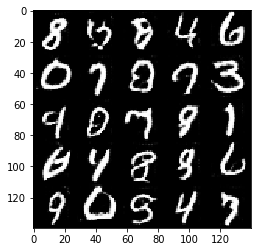

Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 0.6361
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 1.4221... Generator Loss: 0.5772
Epoch 2/2... Discriminator Loss: 1.4935... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 1.4626... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.4678... Generator Loss: 0.5591
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.6248
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.8798... Generator Loss: 0.3182
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.7766


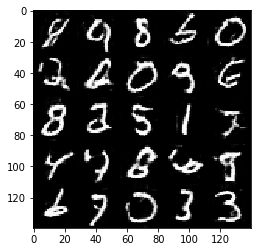

Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.6119... Generator Loss: 0.4409
Epoch 2/2... Discriminator Loss: 1.5344... Generator Loss: 0.5220
Epoch 2/2... Discriminator Loss: 1.6394... Generator Loss: 0.4800
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.6347
Epoch 2/2... Discriminator Loss: 1.3544... Generator Loss: 0.8069
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.8349
Epoch 2/2... Discriminator Loss: 1.4145... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.6003
Epoch 2/2... Discriminator Loss: 1.5105... Generator Loss: 0.5959


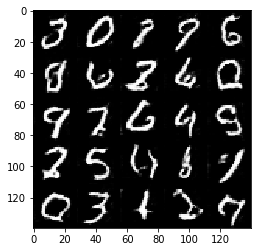

Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 1.5047... Generator Loss: 0.5552
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 1.4097... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.6248
Epoch 2/2... Discriminator Loss: 1.5782... Generator Loss: 0.4408
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.9438
Epoch 2/2... Discriminator Loss: 1.7023... Generator Loss: 0.5031
Epoch 2/2... Discriminator Loss: 1.5829... Generator Loss: 0.4088


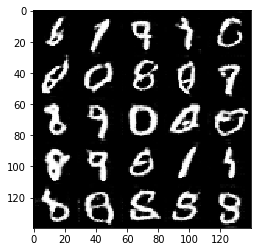

Epoch 2/2... Discriminator Loss: 1.4100... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 0.7124
Epoch 2/2... Discriminator Loss: 1.5293... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.4582... Generator Loss: 0.6861
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.5750
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 1.4853... Generator Loss: 0.6345
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.6347
Epoch 2/2... Discriminator Loss: 1.5984... Generator Loss: 0.3861
Epoch 2/2... Discriminator Loss: 1.4630... Generator Loss: 0.5519


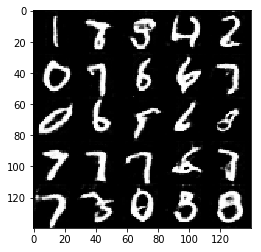

Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.6333
Epoch 2/2... Discriminator Loss: 1.4340... Generator Loss: 0.5841
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.5074
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.6807
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 1.4911... Generator Loss: 0.6416
Epoch 2/2... Discriminator Loss: 1.5551... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 1.4590... Generator Loss: 0.6237


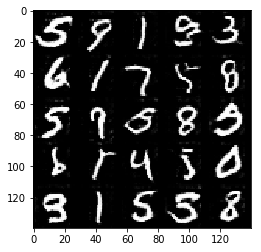

Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.6536
Epoch 2/2... Discriminator Loss: 1.5571... Generator Loss: 1.0744
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.9559
Epoch 2/2... Discriminator Loss: 1.5097... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.6294... Generator Loss: 0.3962
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.6893... Generator Loss: 0.5786
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 0.7318


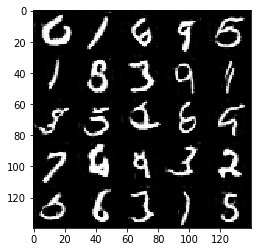

Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.6769... Generator Loss: 0.3667
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.4127... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.2958... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 1.4476... Generator Loss: 0.7922
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.6624


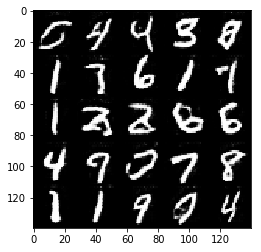

Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.7144
Epoch 2/2... Discriminator Loss: 1.5785... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.6370... Generator Loss: 0.6680
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.5183
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 1.5188... Generator Loss: 0.5685
Epoch 2/2... Discriminator Loss: 1.5006... Generator Loss: 0.5998
Epoch 2/2... Discriminator Loss: 1.4197... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.8443


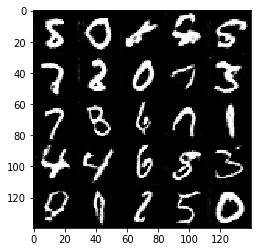

Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 1.4629... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 1.4508... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 1.3695... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 1.5471... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.5396... Generator Loss: 0.4814
Epoch 2/2... Discriminator Loss: 1.2517... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 1.5482... Generator Loss: 0.6290


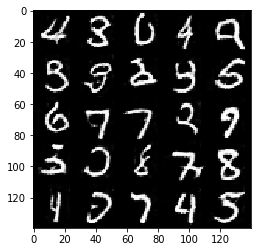

Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 1.5444... Generator Loss: 0.5010
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.5966
Epoch 2/2... Discriminator Loss: 1.4407... Generator Loss: 0.4818
Epoch 2/2... Discriminator Loss: 1.5609... Generator Loss: 0.4683
Epoch 2/2... Discriminator Loss: 1.5944... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 0.7673
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 1.4599... Generator Loss: 0.6032


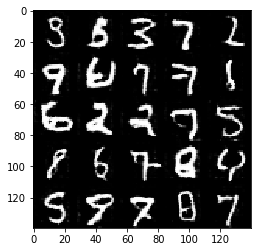

Epoch 2/2... Discriminator Loss: 1.7160... Generator Loss: 0.3662
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 1.5809... Generator Loss: 0.4579
Epoch 2/2... Discriminator Loss: 1.4570... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.6798
Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 1.6542... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.8374
Epoch 2/2... Discriminator Loss: 1.8468... Generator Loss: 0.3214
Epoch 2/2... Discriminator Loss: 1.8148... Generator Loss: 0.3865


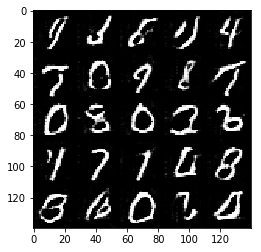

Epoch 2/2... Discriminator Loss: 1.1855... Generator Loss: 1.3866
Epoch 2/2... Discriminator Loss: 1.5219... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.5610... Generator Loss: 0.6529
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.7506
Epoch 2/2... Discriminator Loss: 1.5702... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.6167
Epoch 2/2... Discriminator Loss: 1.6133... Generator Loss: 0.4372
Epoch 2/2... Discriminator Loss: 1.5414... Generator Loss: 0.5254
Epoch 2/2... Discriminator Loss: 1.4535... Generator Loss: 0.5993


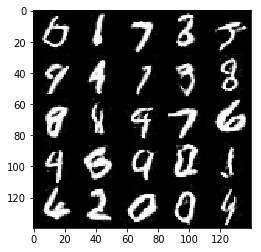

Epoch 2/2... Discriminator Loss: 1.4150... Generator Loss: 0.9925
Epoch 2/2... Discriminator Loss: 1.4655... Generator Loss: 0.6112
Epoch 2/2... Discriminator Loss: 1.2833... Generator Loss: 0.9155
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 0.6111


In [26]:
batch_size = 32
z_dim = 100        
learning_rate = 0.0002   
beta1 = 0.5   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.2692... Generator Loss: 0.0209
Epoch 1/1... Discriminator Loss: 2.1955... Generator Loss: 1.8443
Epoch 1/1... Discriminator Loss: 3.5442... Generator Loss: 0.3359
Epoch 1/1... Discriminator Loss: 2.7300... Generator Loss: 0.2262
Epoch 1/1... Discriminator Loss: 2.6884... Generator Loss: 0.2649
Epoch 1/1... Discriminator Loss: 2.5544... Generator Loss: 0.4188
Epoch 1/1... Discriminator Loss: 2.1315... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 2.2749... Generator Loss: 0.4156
Epoch 1/1... Discriminator Loss: 2.0835... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 1.8401... Generator Loss: 0.5630


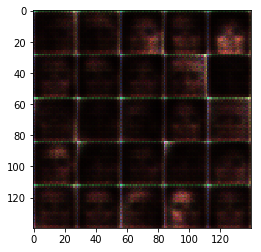

Epoch 1/1... Discriminator Loss: 1.8440... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.8553... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.8294... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 1.7003... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.8709... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.7698... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.7004... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.7506... Generator Loss: 0.5180


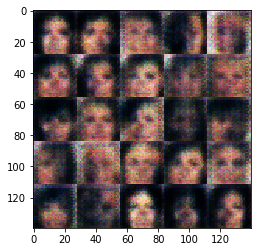

Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.8212... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.6742... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.7038... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.7196... Generator Loss: 0.5316


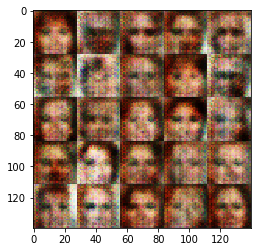

Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.7094... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.6444... Generator Loss: 0.6780


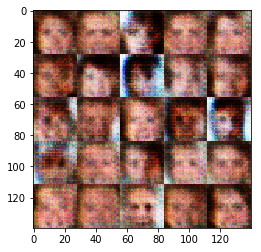

Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7520


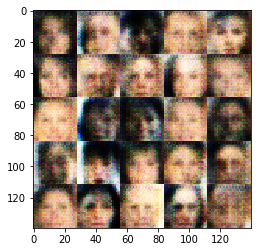

Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.7312


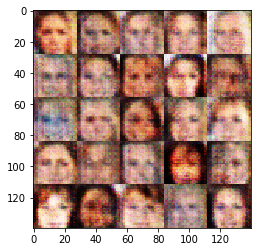

Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.7076... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.8384


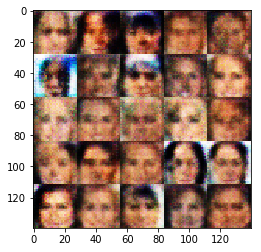

Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7337


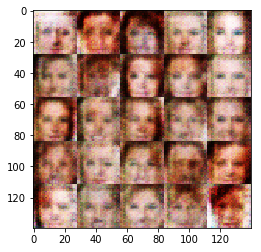

Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.8783


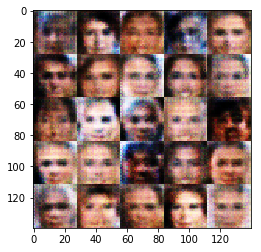

Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7518


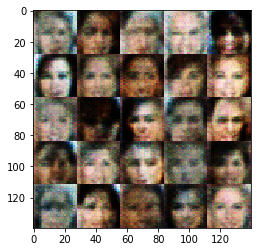

Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.7485


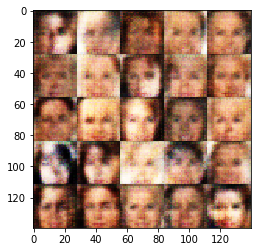

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.7077... Generator Loss: 0.5212
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.6908


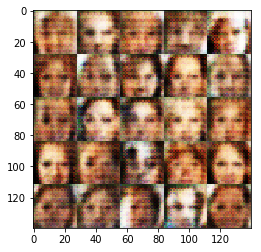

Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6935


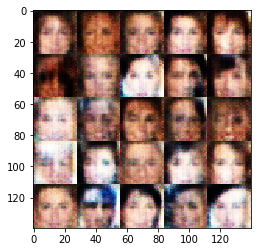

Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7109


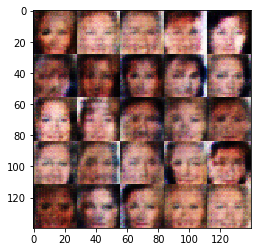

Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.7092


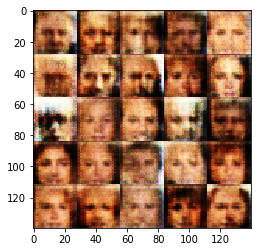

Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7964


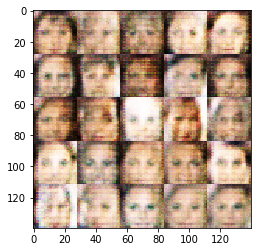

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.6353... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7722


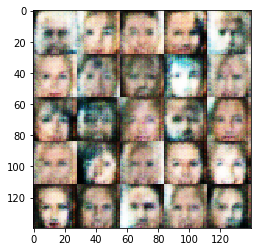

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.6192


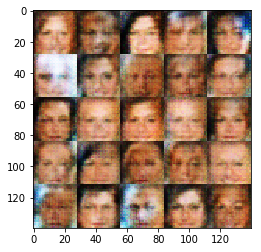

Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6717


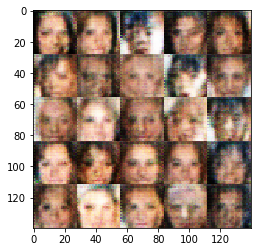

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7711


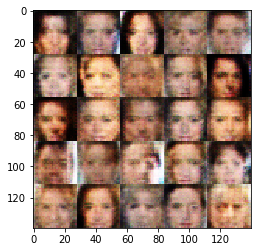

Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6157


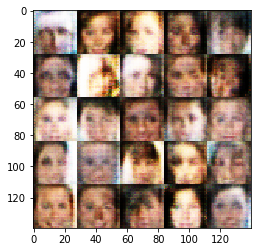

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8030


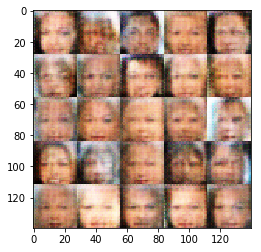

Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7601


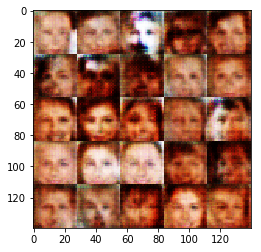

Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.8339


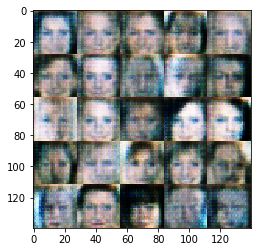

Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7007


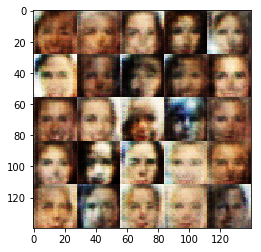

Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7746


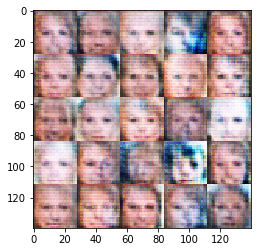

Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7258


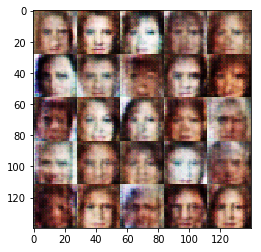

Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.8560


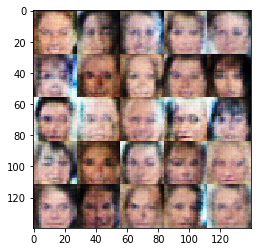

Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6943


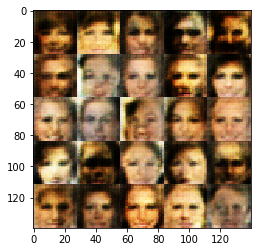

Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6870


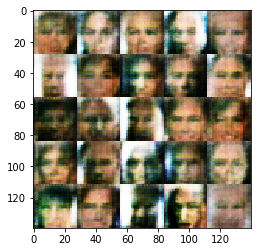

Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.7467


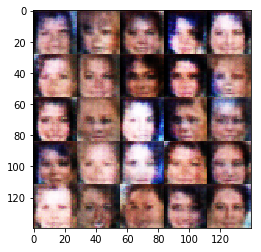

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.8386


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002  
beta1 = 0.5  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.